In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils
import pickle

font = {
        'weight' : 'bold',
        'size'   : 40}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['figure.figsize'] = [9, 5.5]
plt.rcParams['figure.dpi'] = 300
plt.rc('font', **font)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

In [2]:
# For E-BASS experiment
N_TASKS = 400
N_ARMS = 11
OPT_SIZE = 2 # >1
HORIZON = 600

# N_TASKS = 500
# N_ARMS = 30
# OPT_SIZE = 10 # >1
# HORIZON = 4500 #450 for small \tau experiment
N_EXPS = 5 #No. of repeat experiments

GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD) #or None
kwargs = {
          'gap_constrain':None,
          'is_adversarial': True,
          'skip_list': ["G_BASS_FC", "EE"], #"E_BASS"
          'timeout': 45, # maximum duration for each experiment. Unit = minute. -1 = unlimited
          'quiet': True,
          'linewidth': 7, # plotting parameter
          'plot_legend': False,
          'OG_scale': 1,
          'is_non_oblivious': False,
         }

if kwargs['is_adversarial']:
    setting = "Adversarial"
else:
    setting = "Stochastic"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')
utils.verify_params(N_TASKS, N_ARMS, HORIZON, OPT_SIZE, **kwargs)

GAP_THRESHOLD = 0.3314264876212818, actual gap = 0.3314264876212818
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.


## Regret vs Number of tasks

In [3]:
task_list = np.arange(100, 501, 100)
# task_list = np.arange(500, 2501, 500)
(X, regret_dict, title, xlabel, ylabel) = utils.task_exp(N_EXPS, N_ARMS, OPT_SIZE, HORIZON, task_list, **kwargs)
pickle.dump(regret_dict, open("results/tasks.p", "wb"))
pass

  0%|                                                                                 | 0/5 [00:00<?, ?it/s]

WARNING (Phased Elimination): phase 1 duration (810.5099527339041) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (Phased Elimination): phase 1 duration (810.5099527339041) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (7.189407458504942) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (7.189407458504942) must in range [0,1]. Capped at 1.WARNING (Phased Elimination): phase 1 duration (810.5099527339041) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.



100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 342.20it/s]

WARNING (Phased Elimination): phase 1 duration (810.5099527339041) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (7.189407458504942) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (7.189407458504942) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (810.5099527339041) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (7.189407458504942) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (814) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (814) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(130) < tau (600) setting
WARNING (Phased Elimination): phase 1 duration (814) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS: sel

WARNING (Phased Elimination): phase 1 duration (932.5038565124544) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (6.4118817333735025) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (935) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (935) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(172) < tau (600) setting
OS_BASS: self.tau_prime = 172, self.gamma = 0.09506904698147708. If gamma > 1, capped at 1.
WARNING (Phased Elimination): phase 1 duration (932.5038565124544) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (6.4118817333735025) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (932.5038565124544) is larger than the horizon (600) 
=> increase horizon, decrease n

Process Process-3:13:
Process Process-3:11:
Process Process-6:11:
Process Process-6:9:
Process Process-6:14:
Process Process-5:9:
Process Process-2:10:
Process Process-5:11:
Process Process-4:13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-6:13:
Traceback (most recent call last):
Process Process-6:12:
Traceback (most recent call last):
Process Process-5:13:
Process Process-4:10:
Traceback (most recent call last):
Process Process-3:9:
Process Process-3:12:
Process Process-6:10:
  File "/opt/conda/envs/meta-bandit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-3:10:
Traceback (most recent call last):
  File "/opt/conda/envs/meta-bandit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/envs/meta-bandit/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/opt/conda/envs/meta-b

KeyboardInterrupt: 

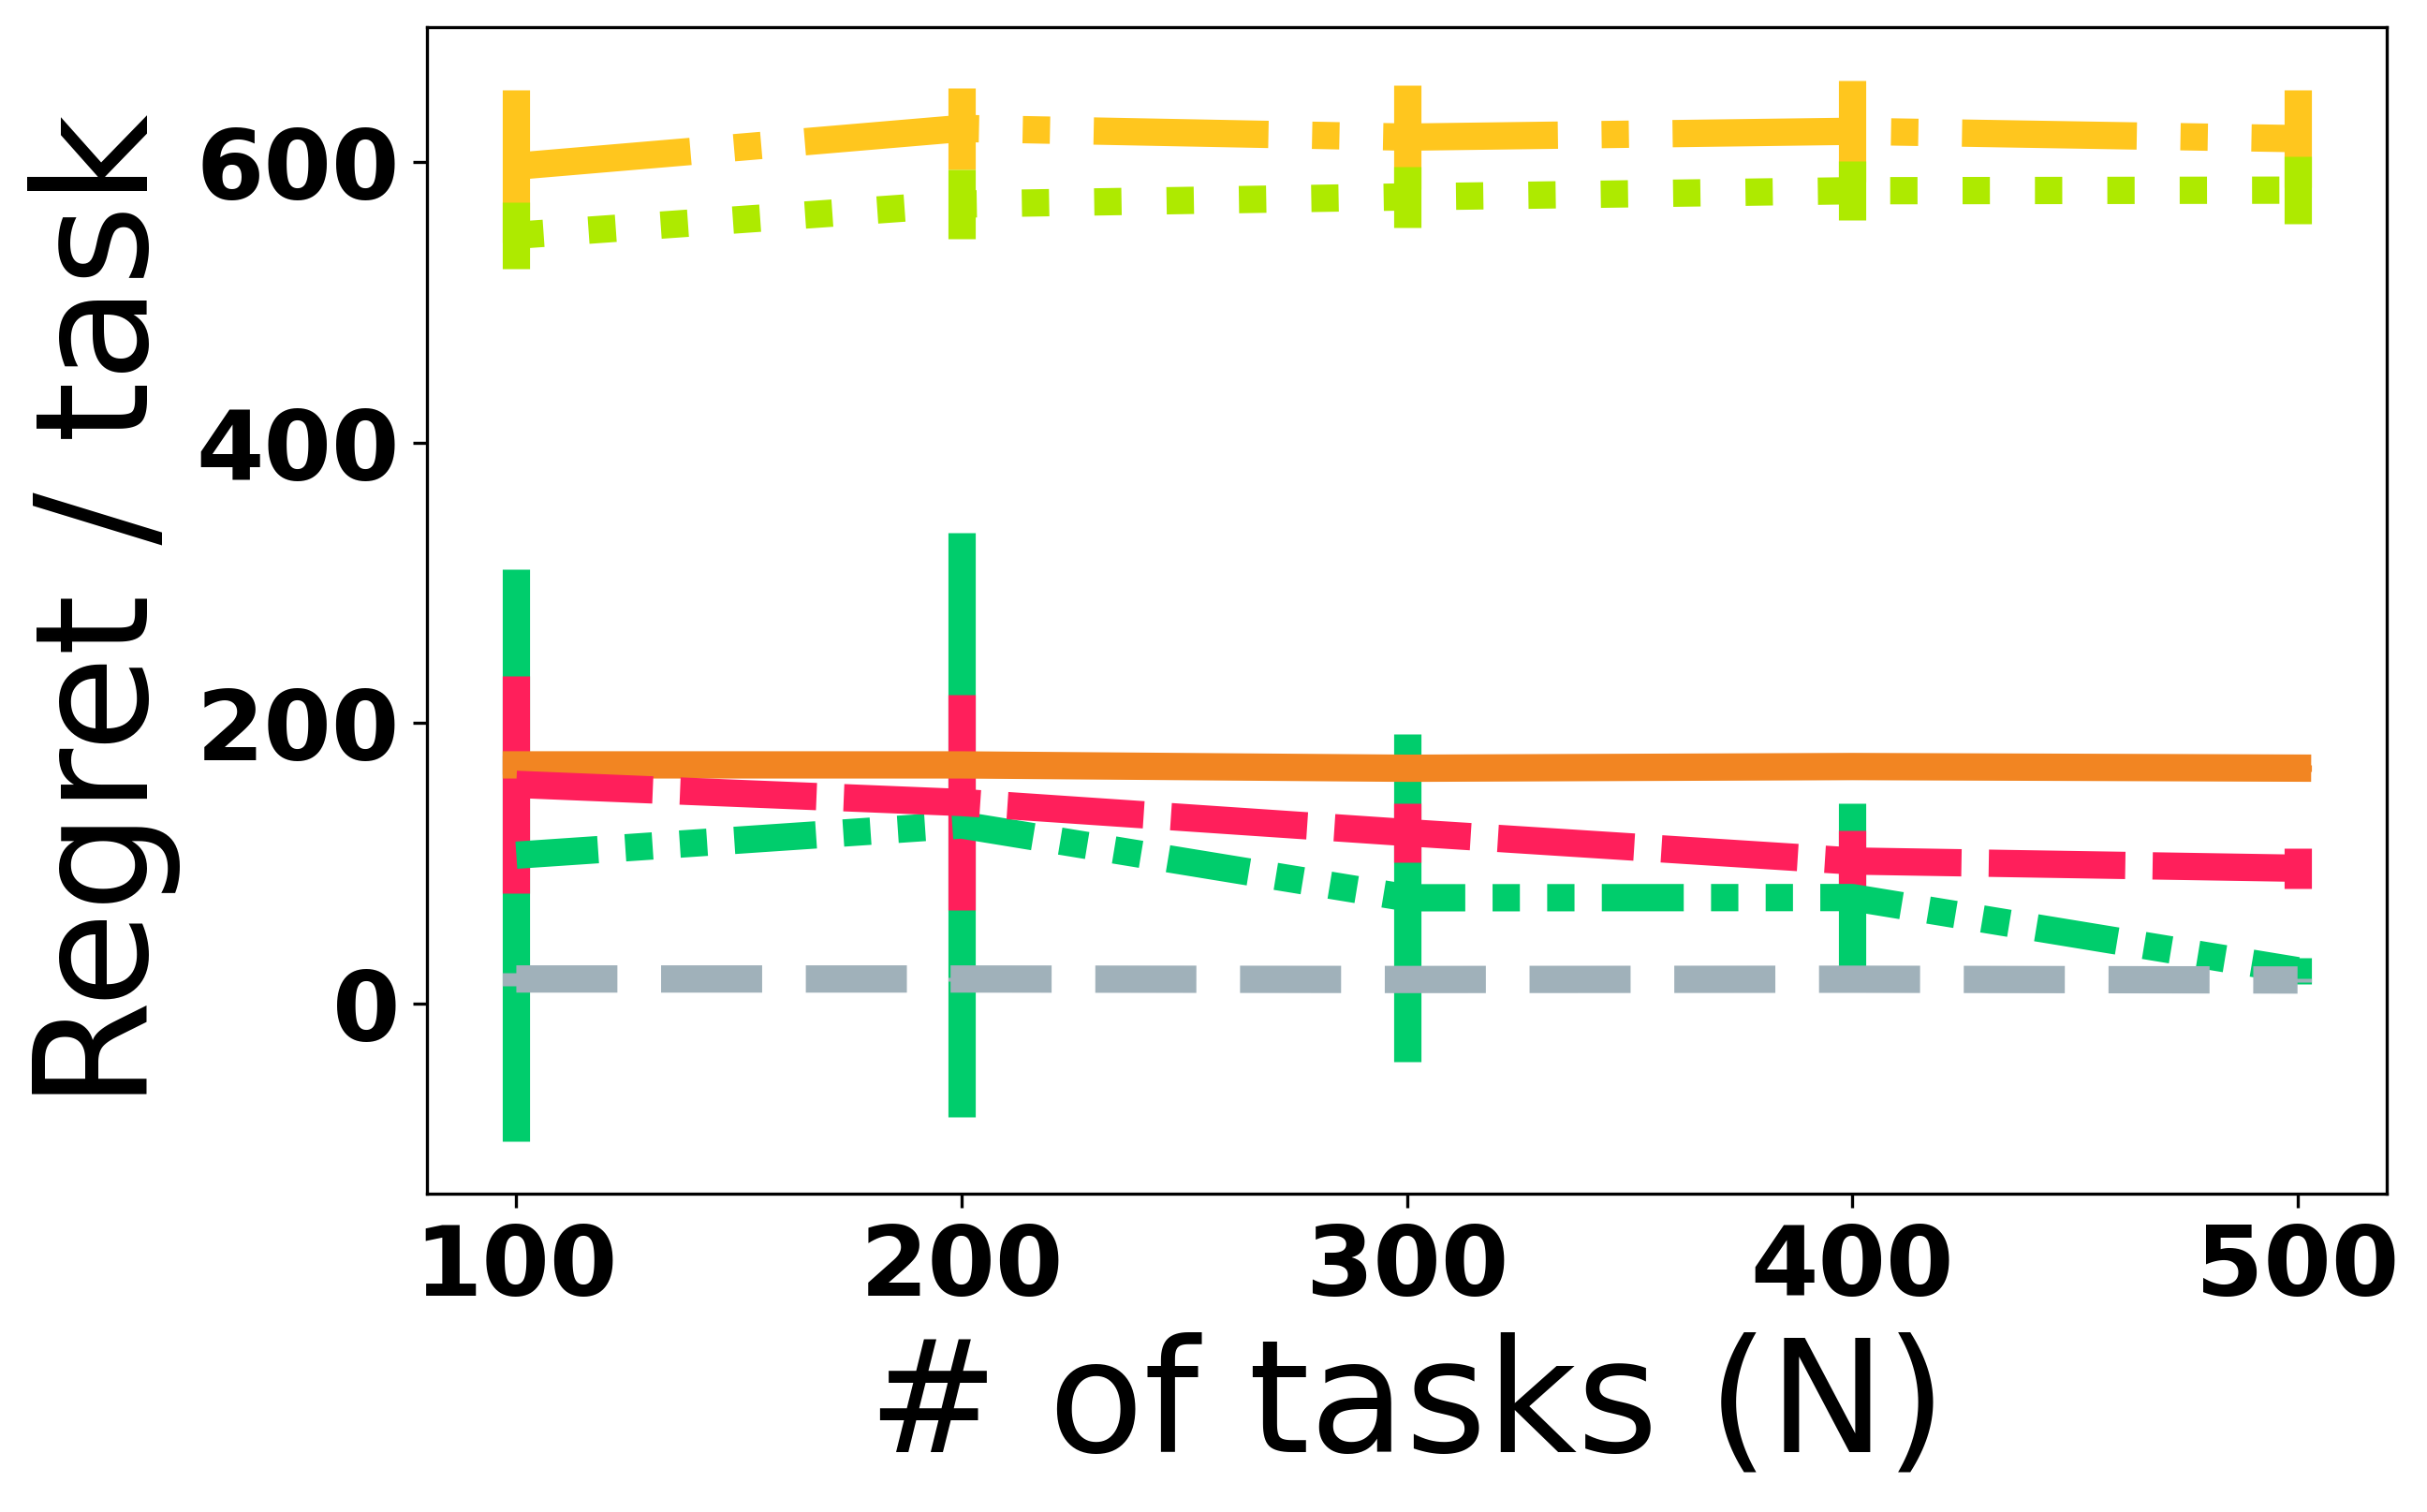

In [98]:
# Plot from loaded cache file
X = np.arange(100, 501, 100)
# X = np.arange(500, 2501, 500)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/tasks.p", "rb"))
utils.plot(X, regret_dict, '', '# of tasks (N)', 'Regret / task', **kwargs)
pass

## Regret vs Horizon

  0%|                                                                                 | 0/5 [00:00<?, ?it/s]

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (500) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (500) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.

100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 139.74it/s]

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (500) 
=> increase horizon, decrease n_arms or/and n_tasks.

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (500) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (500) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (500) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (500) => increase horizon and/or change n_arms.
OS_BASS tau'(211) 

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(227) < tau (600) setting
OS_BASS: self.tau_prime = 227, self.gamma = 0.08276783816455013. If gamma > 1, capped at 1.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decreas

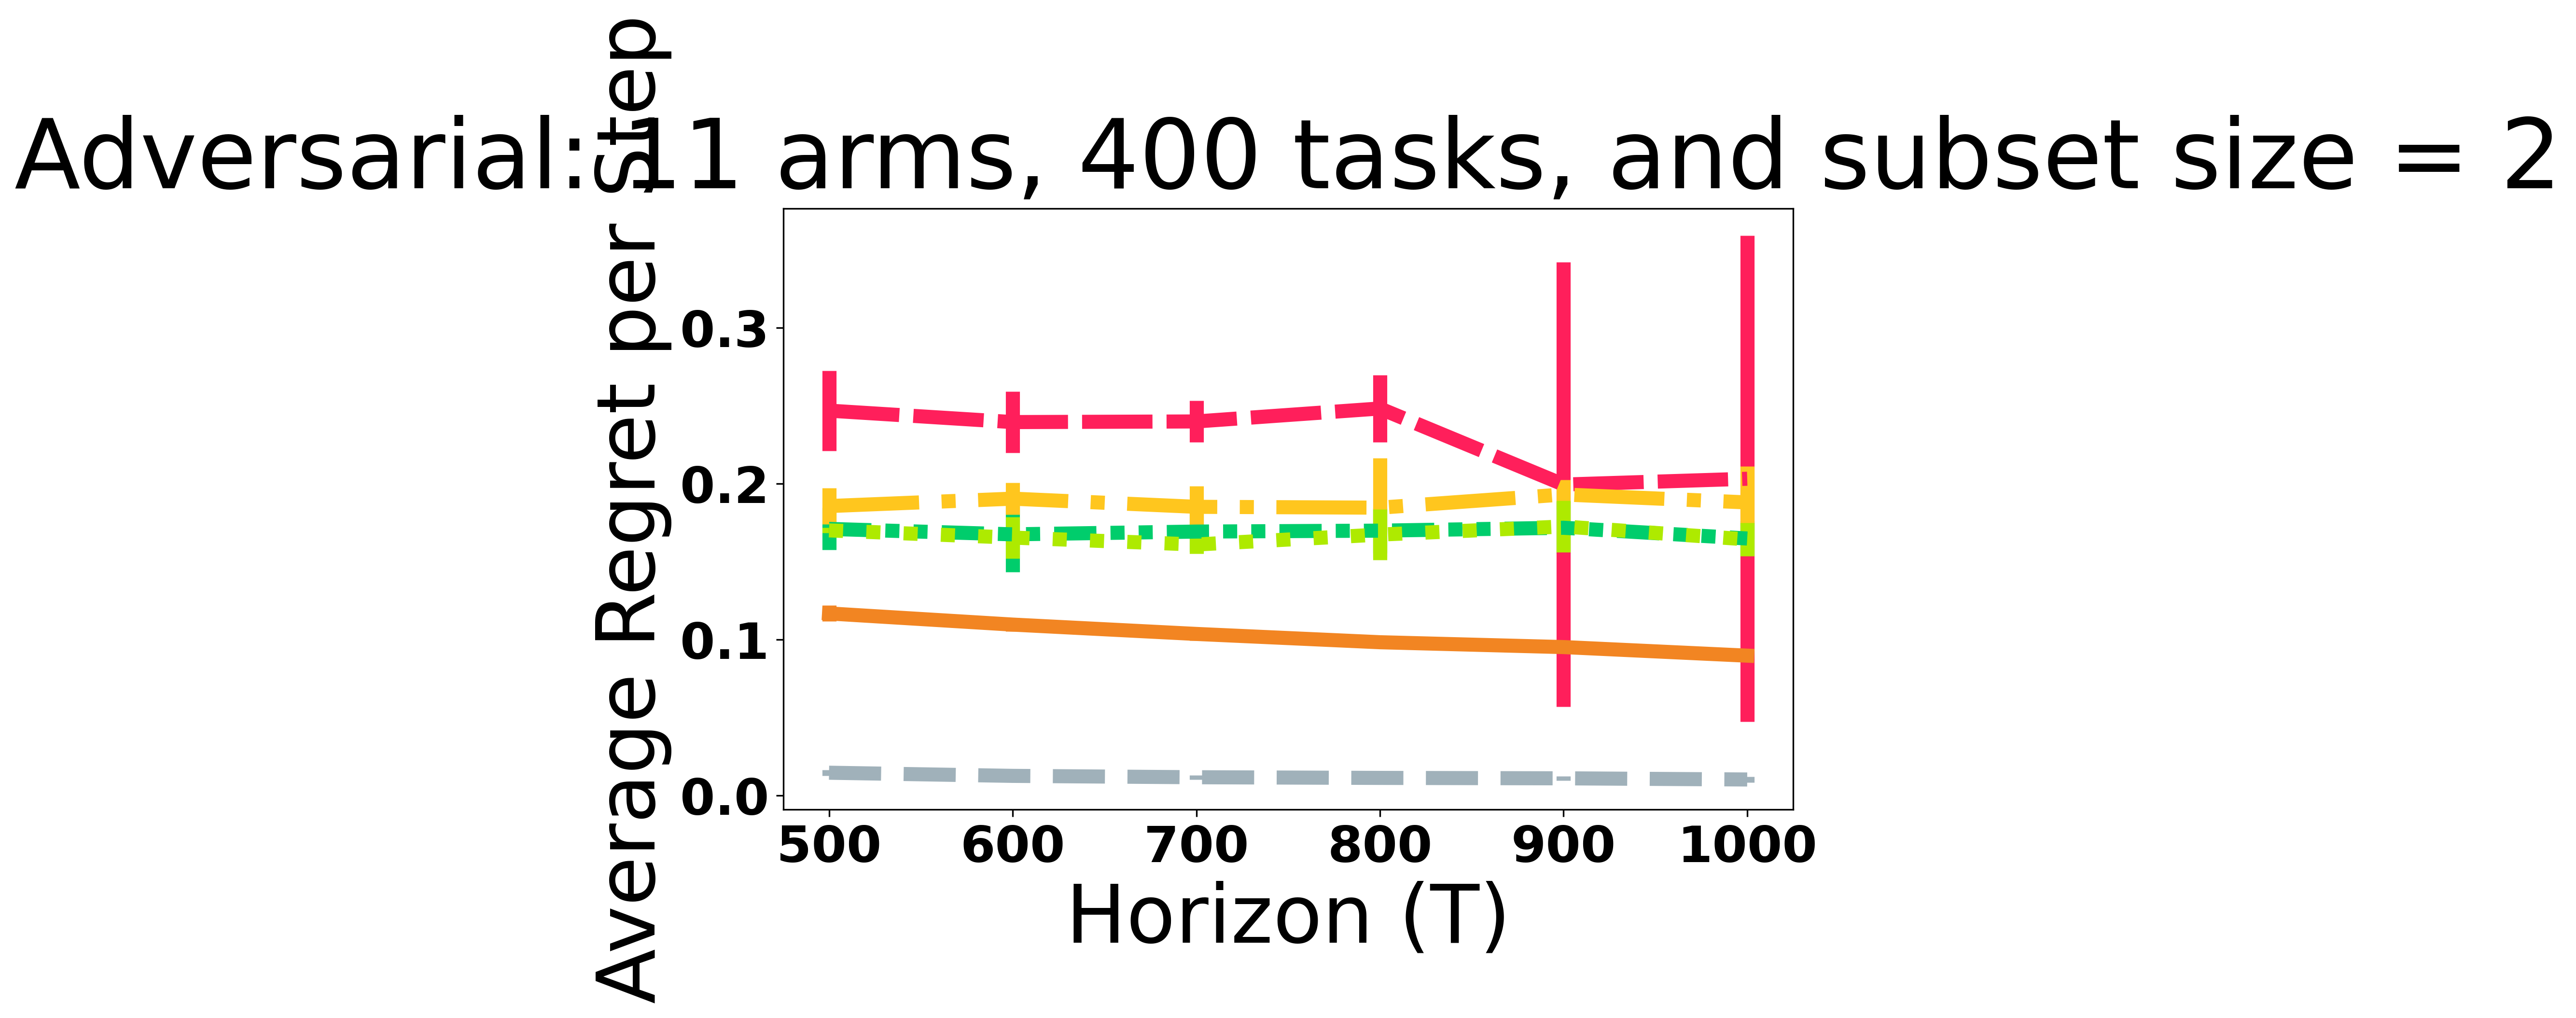

In [83]:
horizon_list = np.arange(500, 1006, 100)
# horizon_list = np.arange(1200, 2006, 200)
# horizon_list = np.arange(500, 1306, 200)
# horizon_list = np.arange(3000, 5006, 500)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
pass

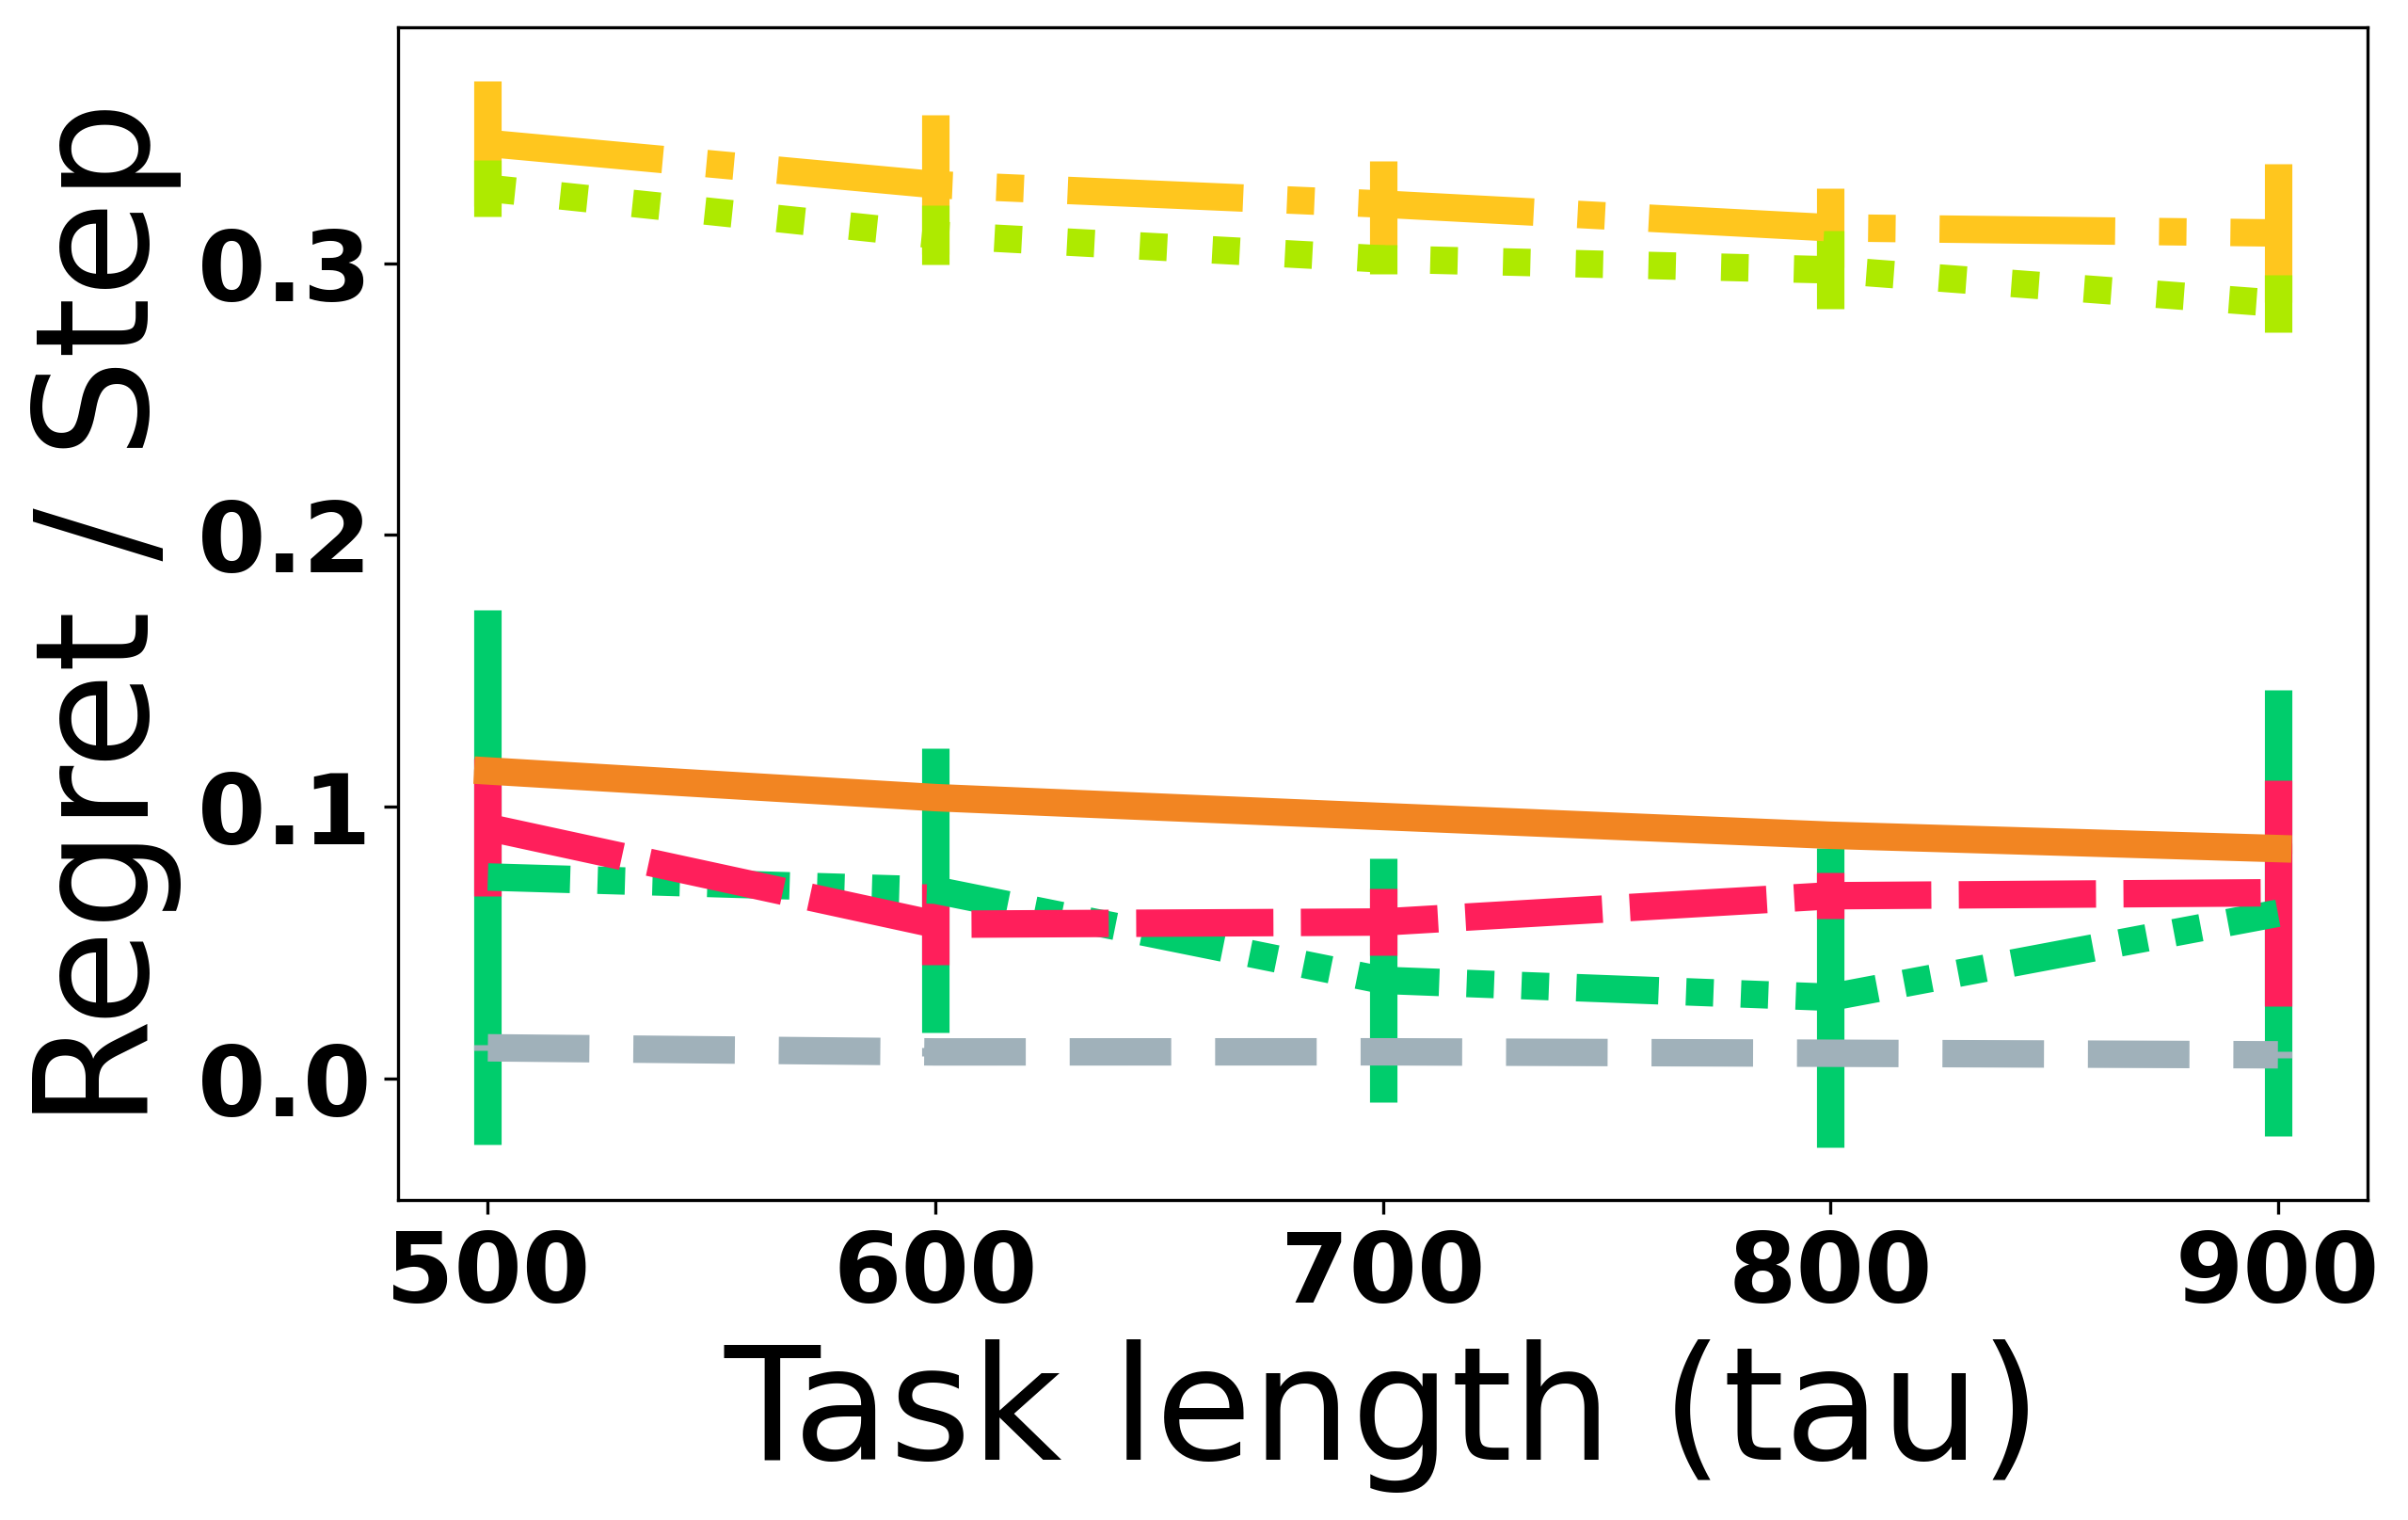

In [99]:
# Plot from loaded cache file
X_h = np.arange(500, 1006, 100)
# X_h = np.arange(300, 506, 50)
# X_h = np.arange(3000, 5006, 500)
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
utils.plot(X_h, regret_dict_h, '', 'Task length (tau)', 'Regret / Step', **kwargs)
# plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

## Regret vs # of arm

  0%|                                                                                 | 0/5 [00:00<?, ?it/s]

WARNING (Phased Elimination): phase 1 duration (958.634327537277) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (Phased Elimination): phase 1 duration (958.634327537277) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (5.399042189739991) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (5.399042189739991) must in range [0,1]. Capped at 1.WARNING (Phased Elimination): phase 1 duration (958.634327537277) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.

100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 128.69it/s]



WARNING (OG baseline): og_gamma (5.399042189739991) must in range [0,1]. Capped at 1.WARNING (Phased Elimination): phase 1 duration (958.634327537277) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.

WARNING (OG baseline): og_gamma (5.399042189739991) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (958.634327537277) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.399042189739991) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (960) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (960) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(231) < tau (600) setting
OS_BASS: self.tau_prime = 231, self.gamma = 0.08213321287936834. If gamma > 1, capped at 1.
WARNING (Phased Elimination): phase 1 duration (

WARNING (Phased Elimination): phase 1 duration (1150.3611930447325) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.8849385598951836) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1152) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (1152) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(224) < tau (600) setting
OS_BASS: self.tau_prime = 224, self.gamma = 0.08338647613608734. If gamma > 1, capped at 1.
WARNING (Phased Elimination): phase 1 duration (1150.3611930447325) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.8849385598951836) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1152) is larger than the horizon (600) => increase horizon and/or change n_arms.

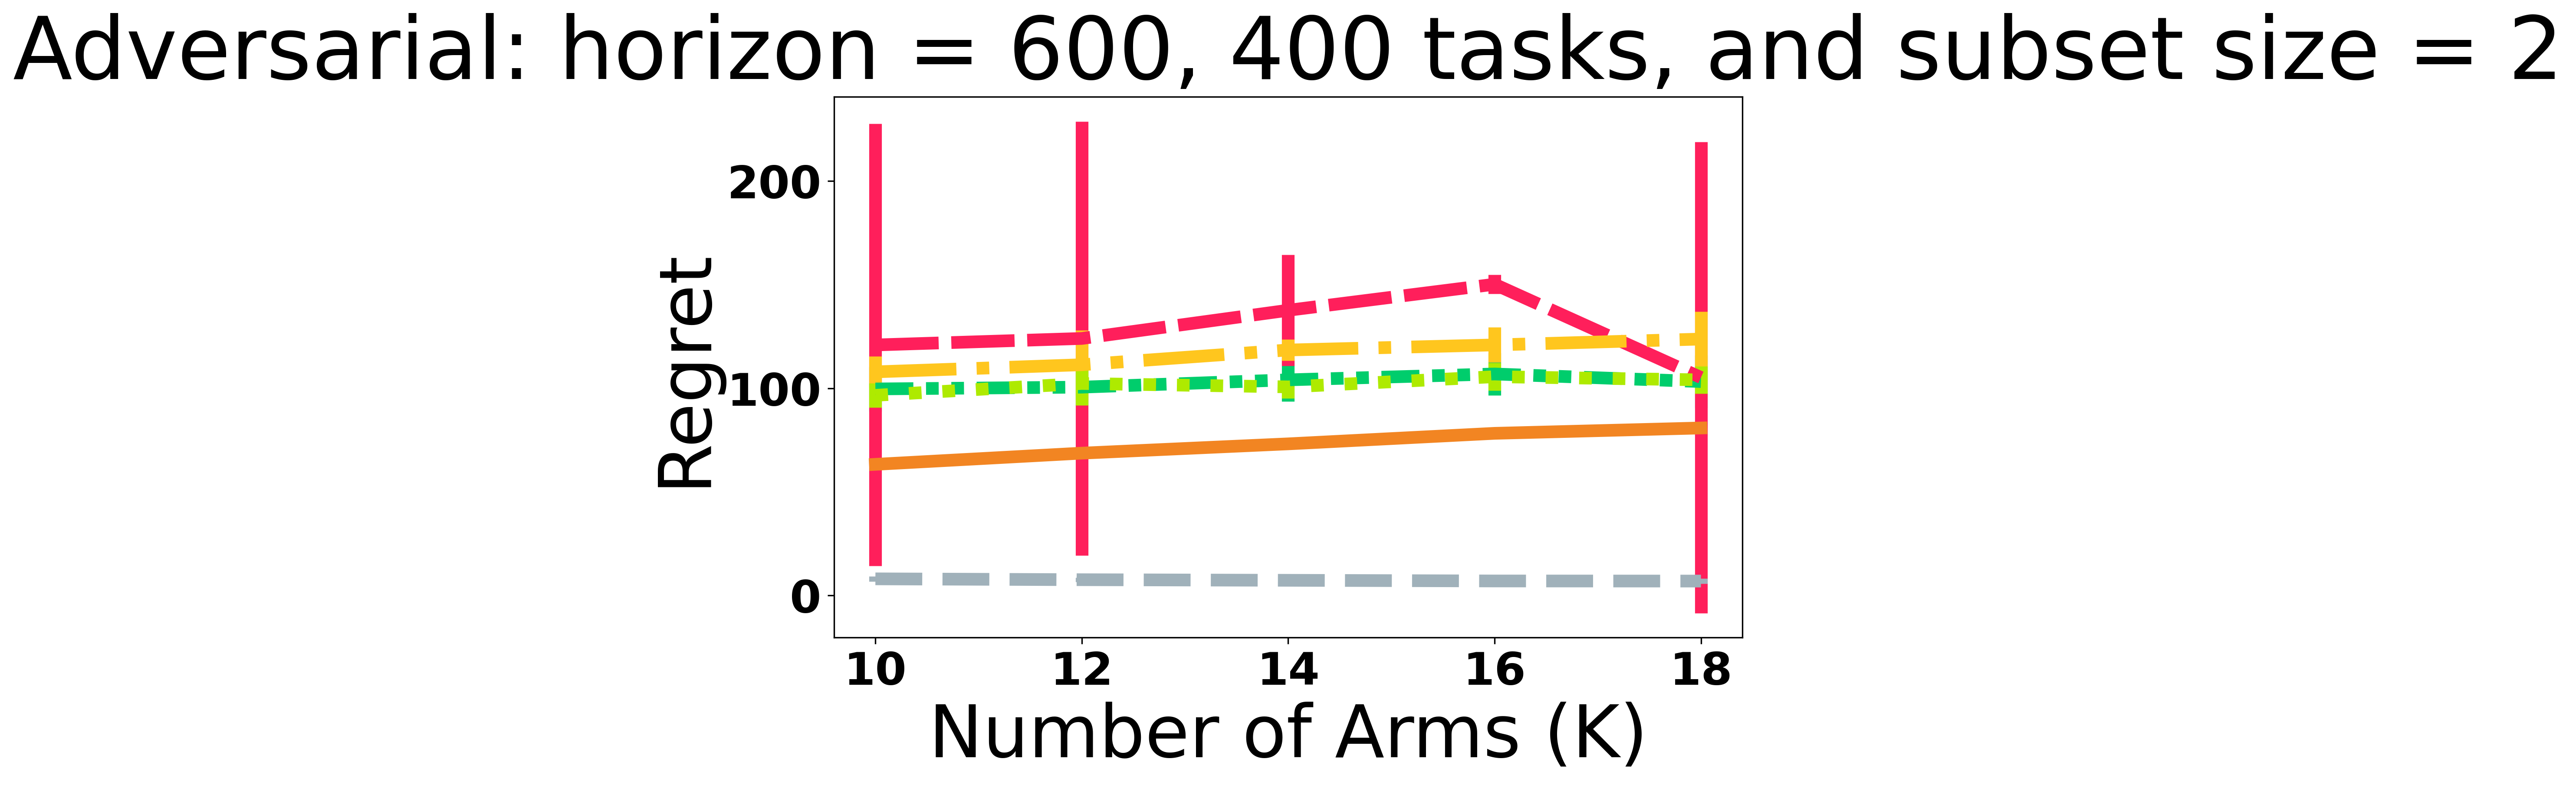

In [85]:
n_arms_list = np.arange(10,19,2)
# n_arms_list = np.arange(25,46,5)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, OPT_SIZE, HORIZON, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
pass

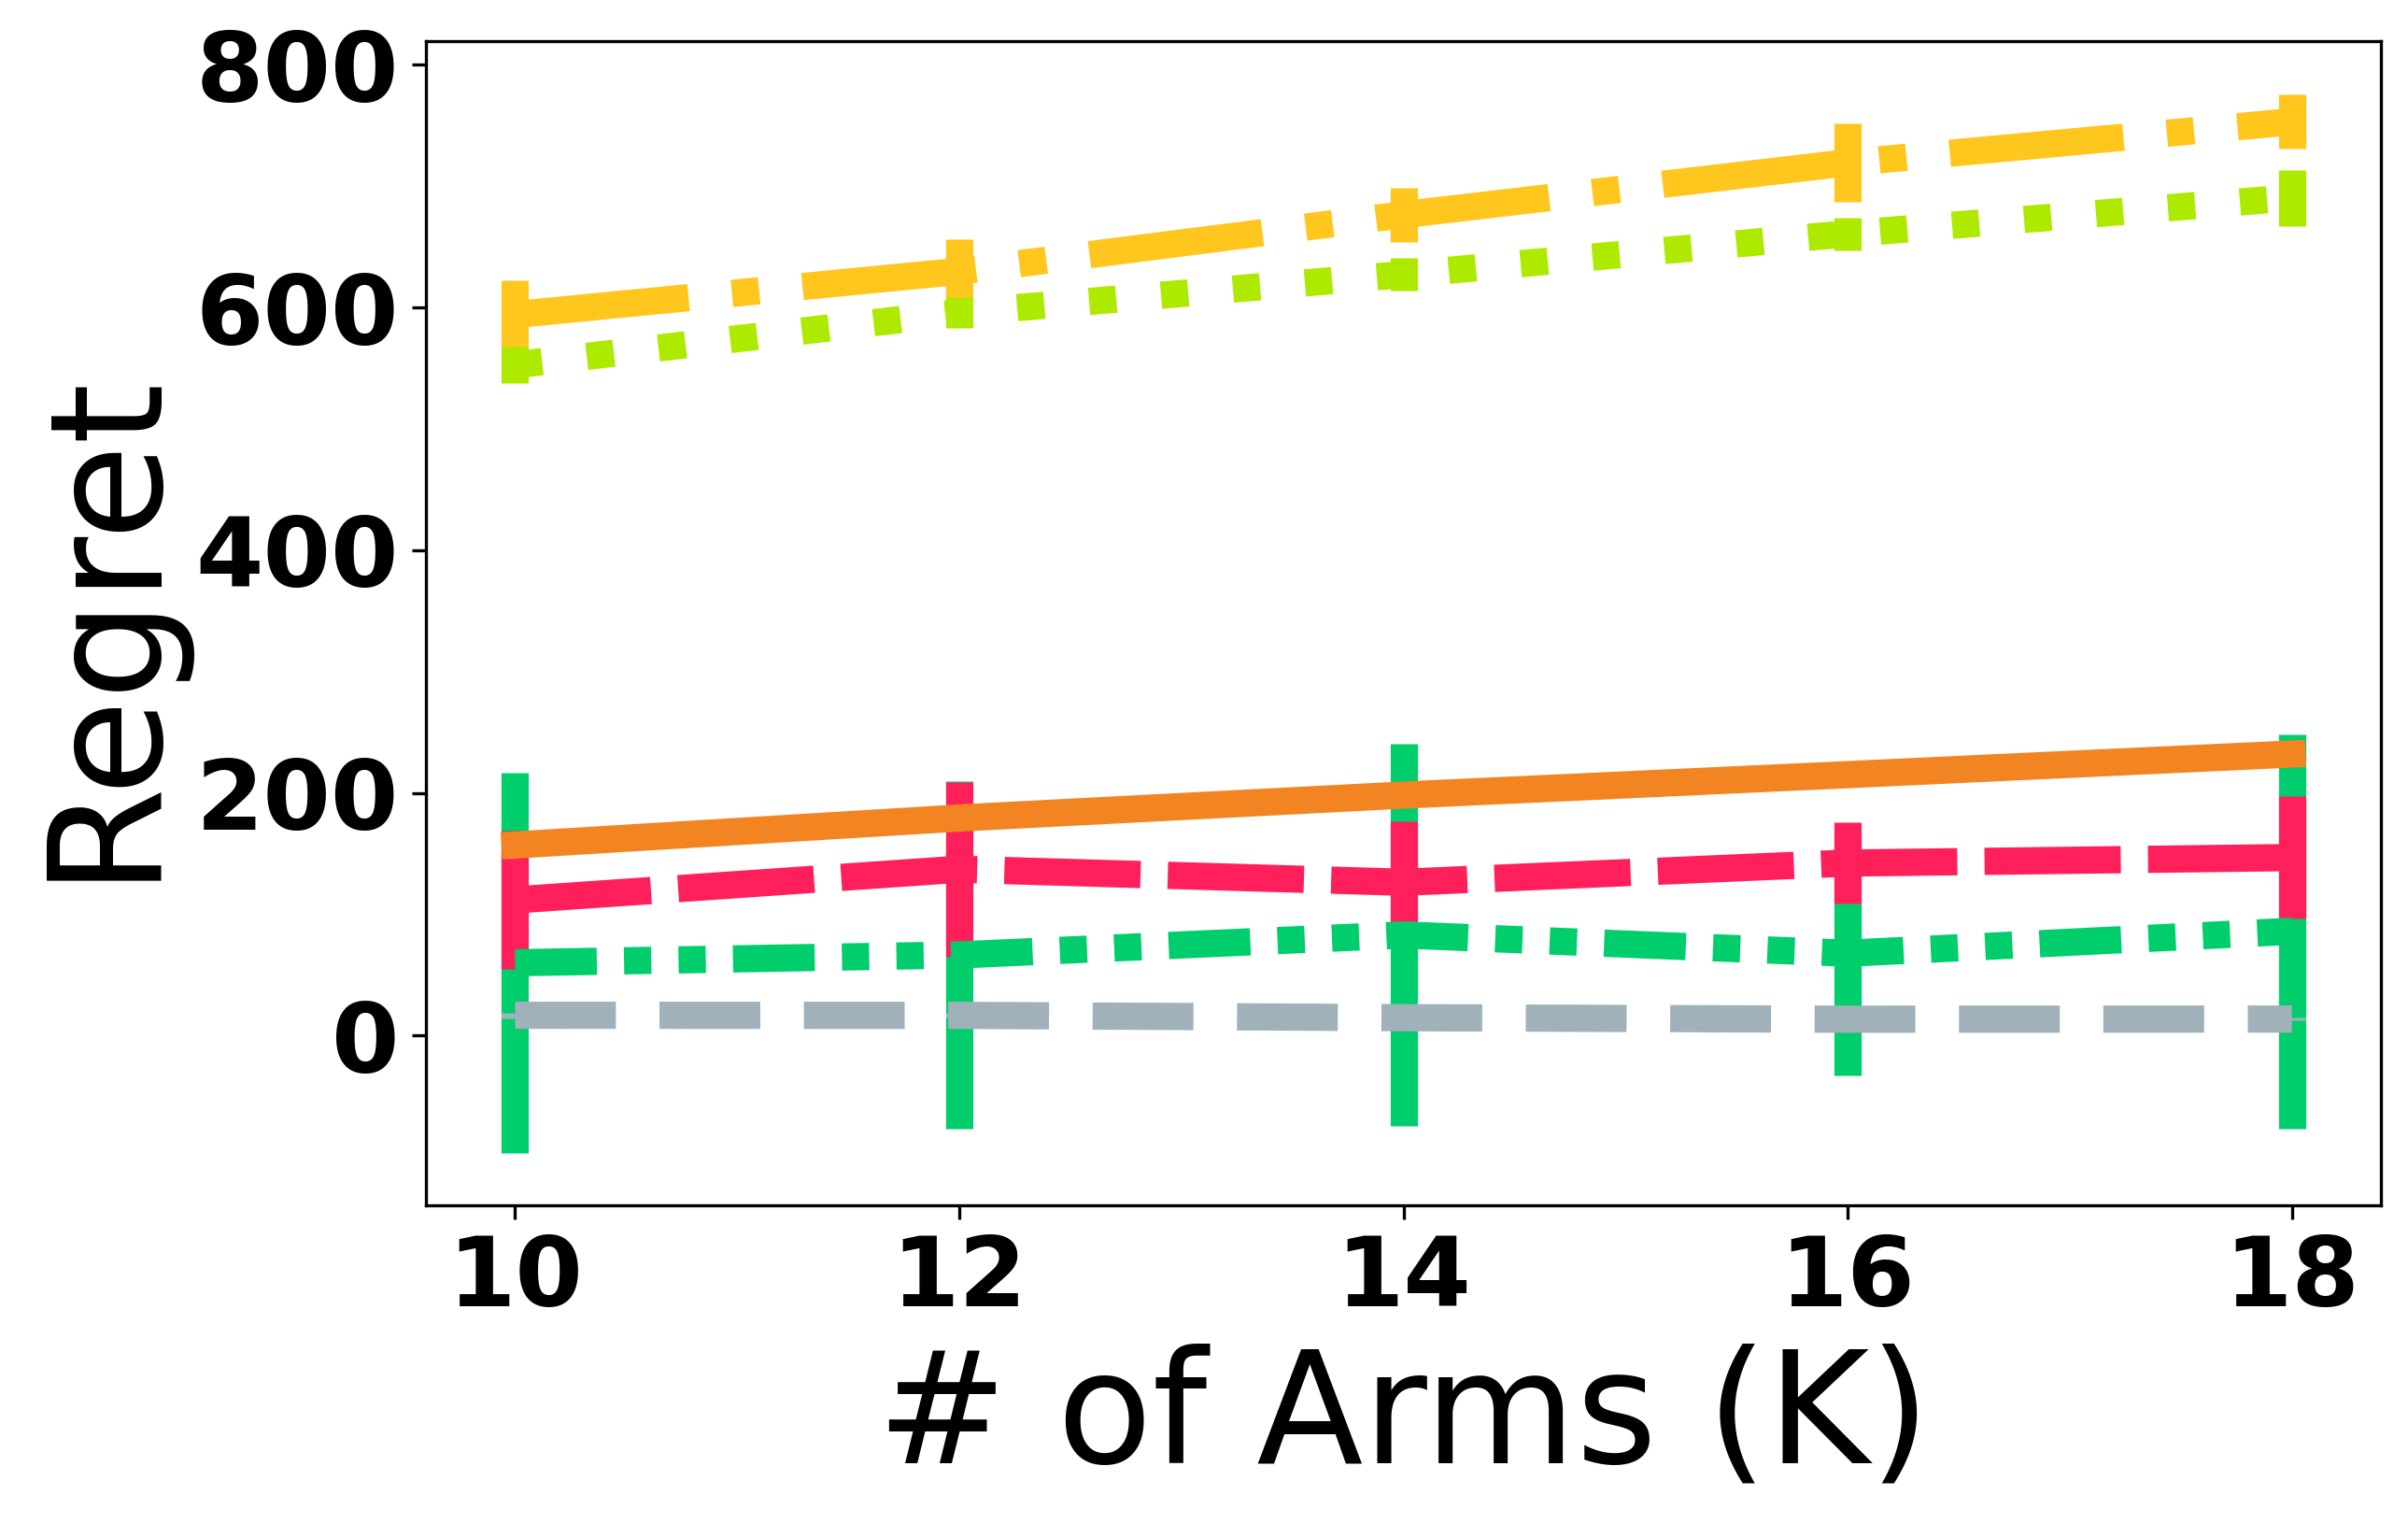

In [100]:
# Plot from loaded cache file
X_b = np.arange(10,19,2)
# X_b = np.arange(25,46,5)
regret_dict_b = pickle.load(open("results/arms.p", "rb"))
utils.plot(X_b, regret_dict_b, '', '# of Arms (K)', 'Regret', **kwargs)

## Regret vs subset size

  0%|                                                                                 | 0/5 [00:00<?, ?it/s]

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.

WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.

100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 116.19it/s]

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.

WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.

WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (5.649184912031993) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
OS_BASS tau'(227) 

WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (11.298369824063986) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase horizon and/or change n_arms.
OG gamma: 1.0180309057508974
OS_BASS tau'(344) < tau (600) setting
OS_BASS: self.tau_prime = 344, self.gamma = 0.09506904698147708. If gamma > 1, capped at 1.
WARNING (Phased Elimination): phase 1 duration (1054.4977602910049) is larger than the horizon (600) 
=> increase horizon, decrease n_arms or/and n_tasks.
WARNING (OG baseline): og_gamma (11.298369824063986) must in range [0,1]. Capped at 1.
WARNING (Phased Elimination): phase 1 duration (1056) is larger than the horizon (600) => increase 

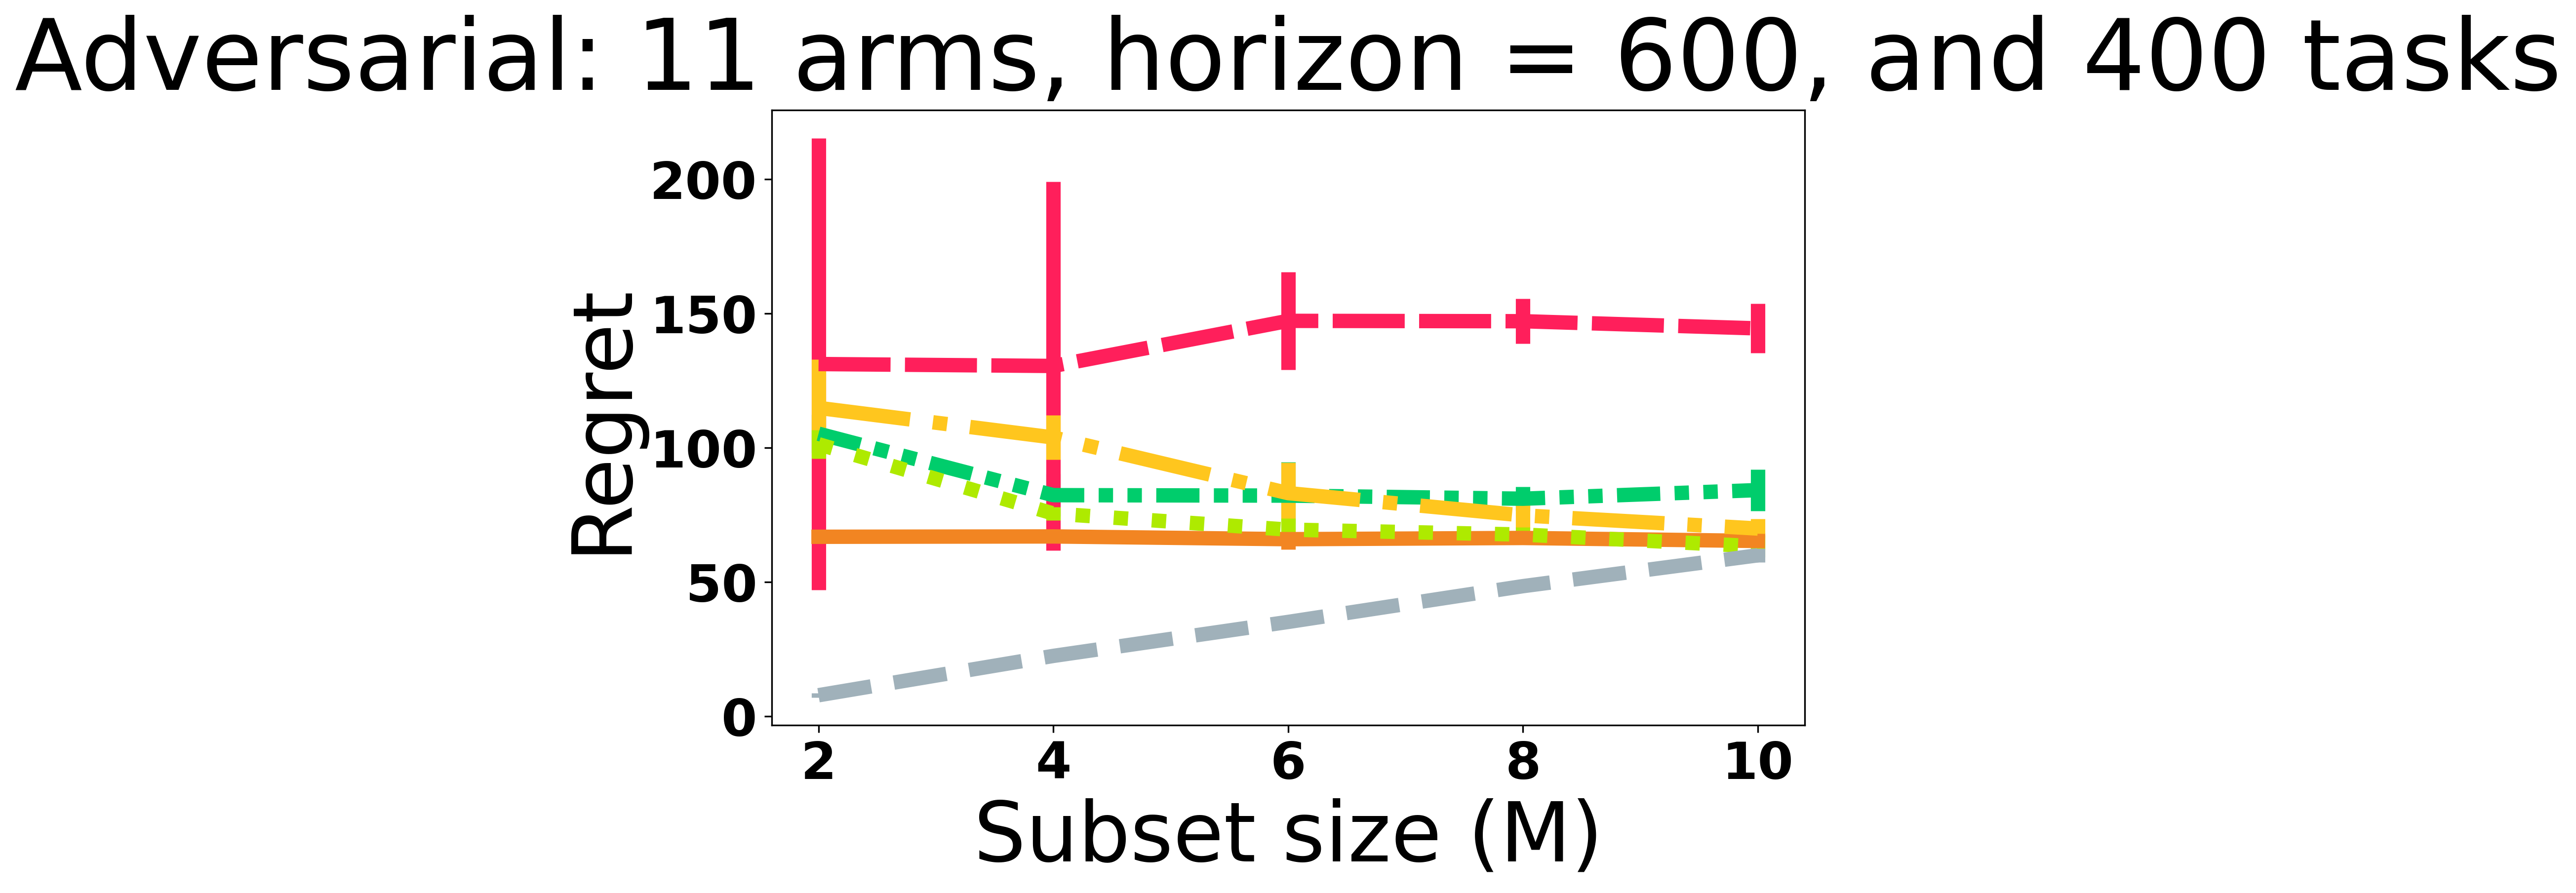

In [88]:
opt_size_list = np.arange(2,11,2)
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = opt_size_list, **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
pass

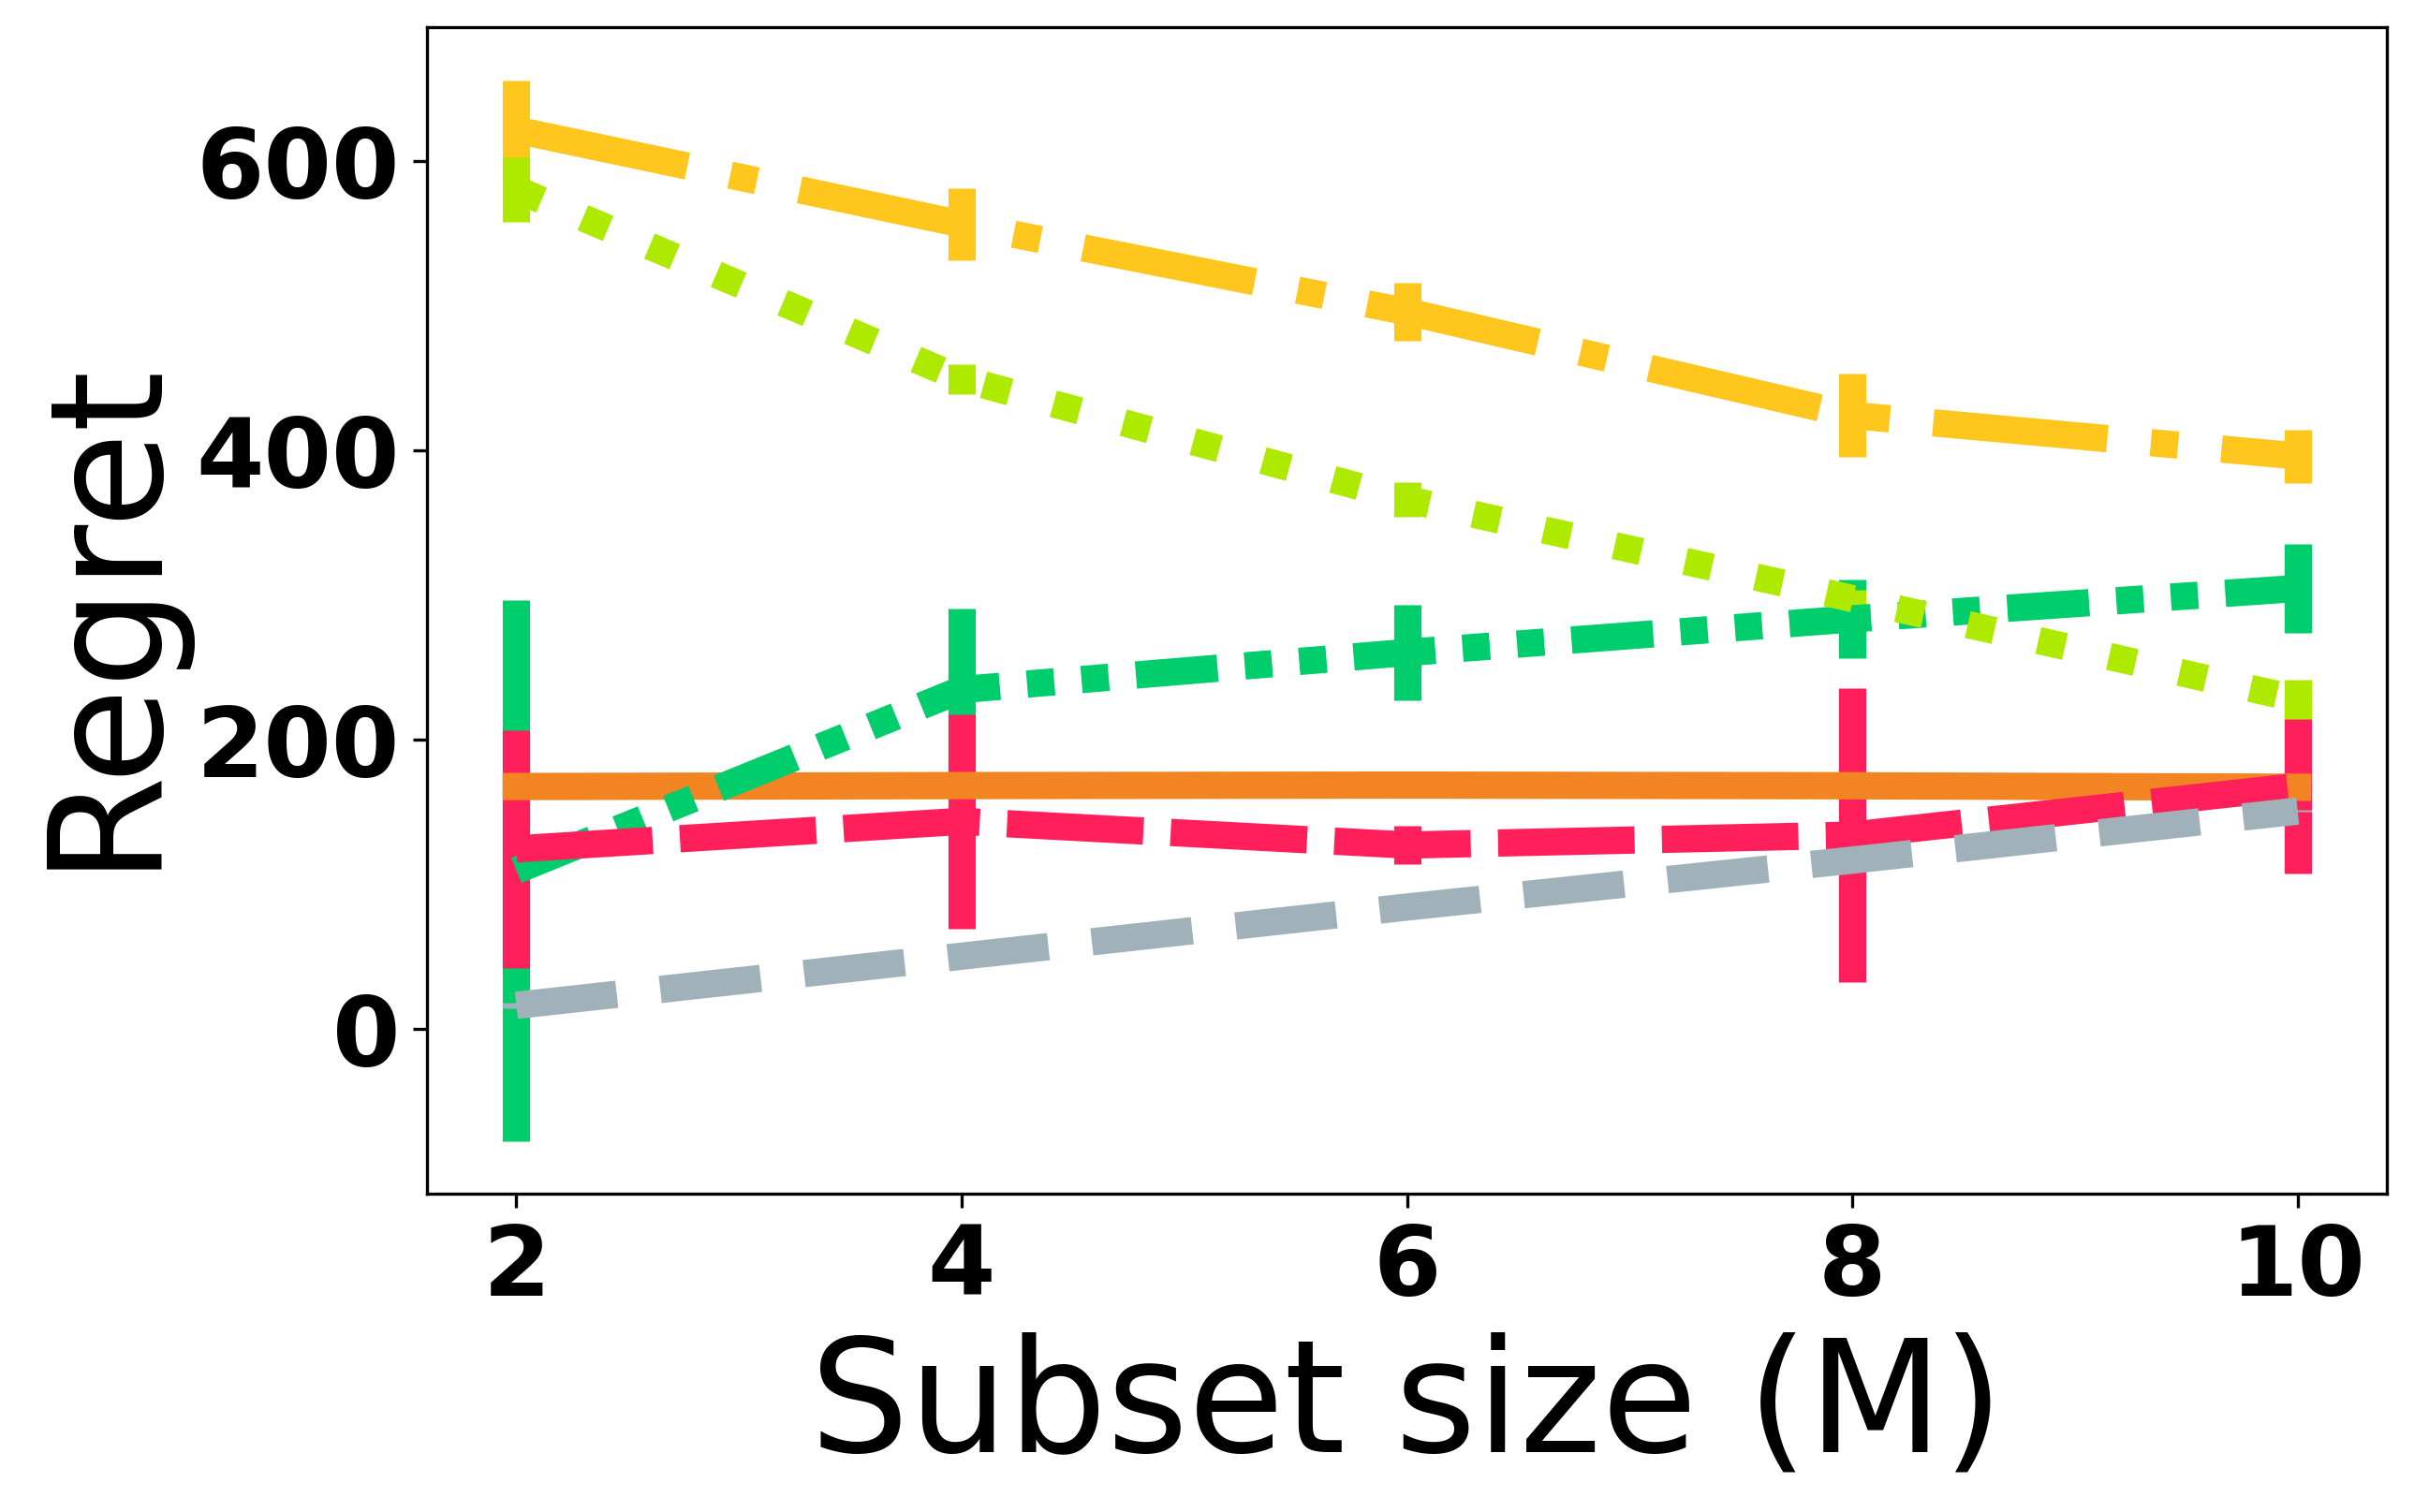

In [101]:
# Plot from loaded cache file
X_e = np.arange(2,11,2)
regret_dict_e = pickle.load(open("results/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, '', 'Subset size (M)', 'Regret', **kwargs)

# Plotting legend code

In [2]:
font = {
        'weight' : 'bold',
        'size'   : 6}

plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams['figure.figsize'] = [9, 5.5] # NIPS format: [9, 5.5]

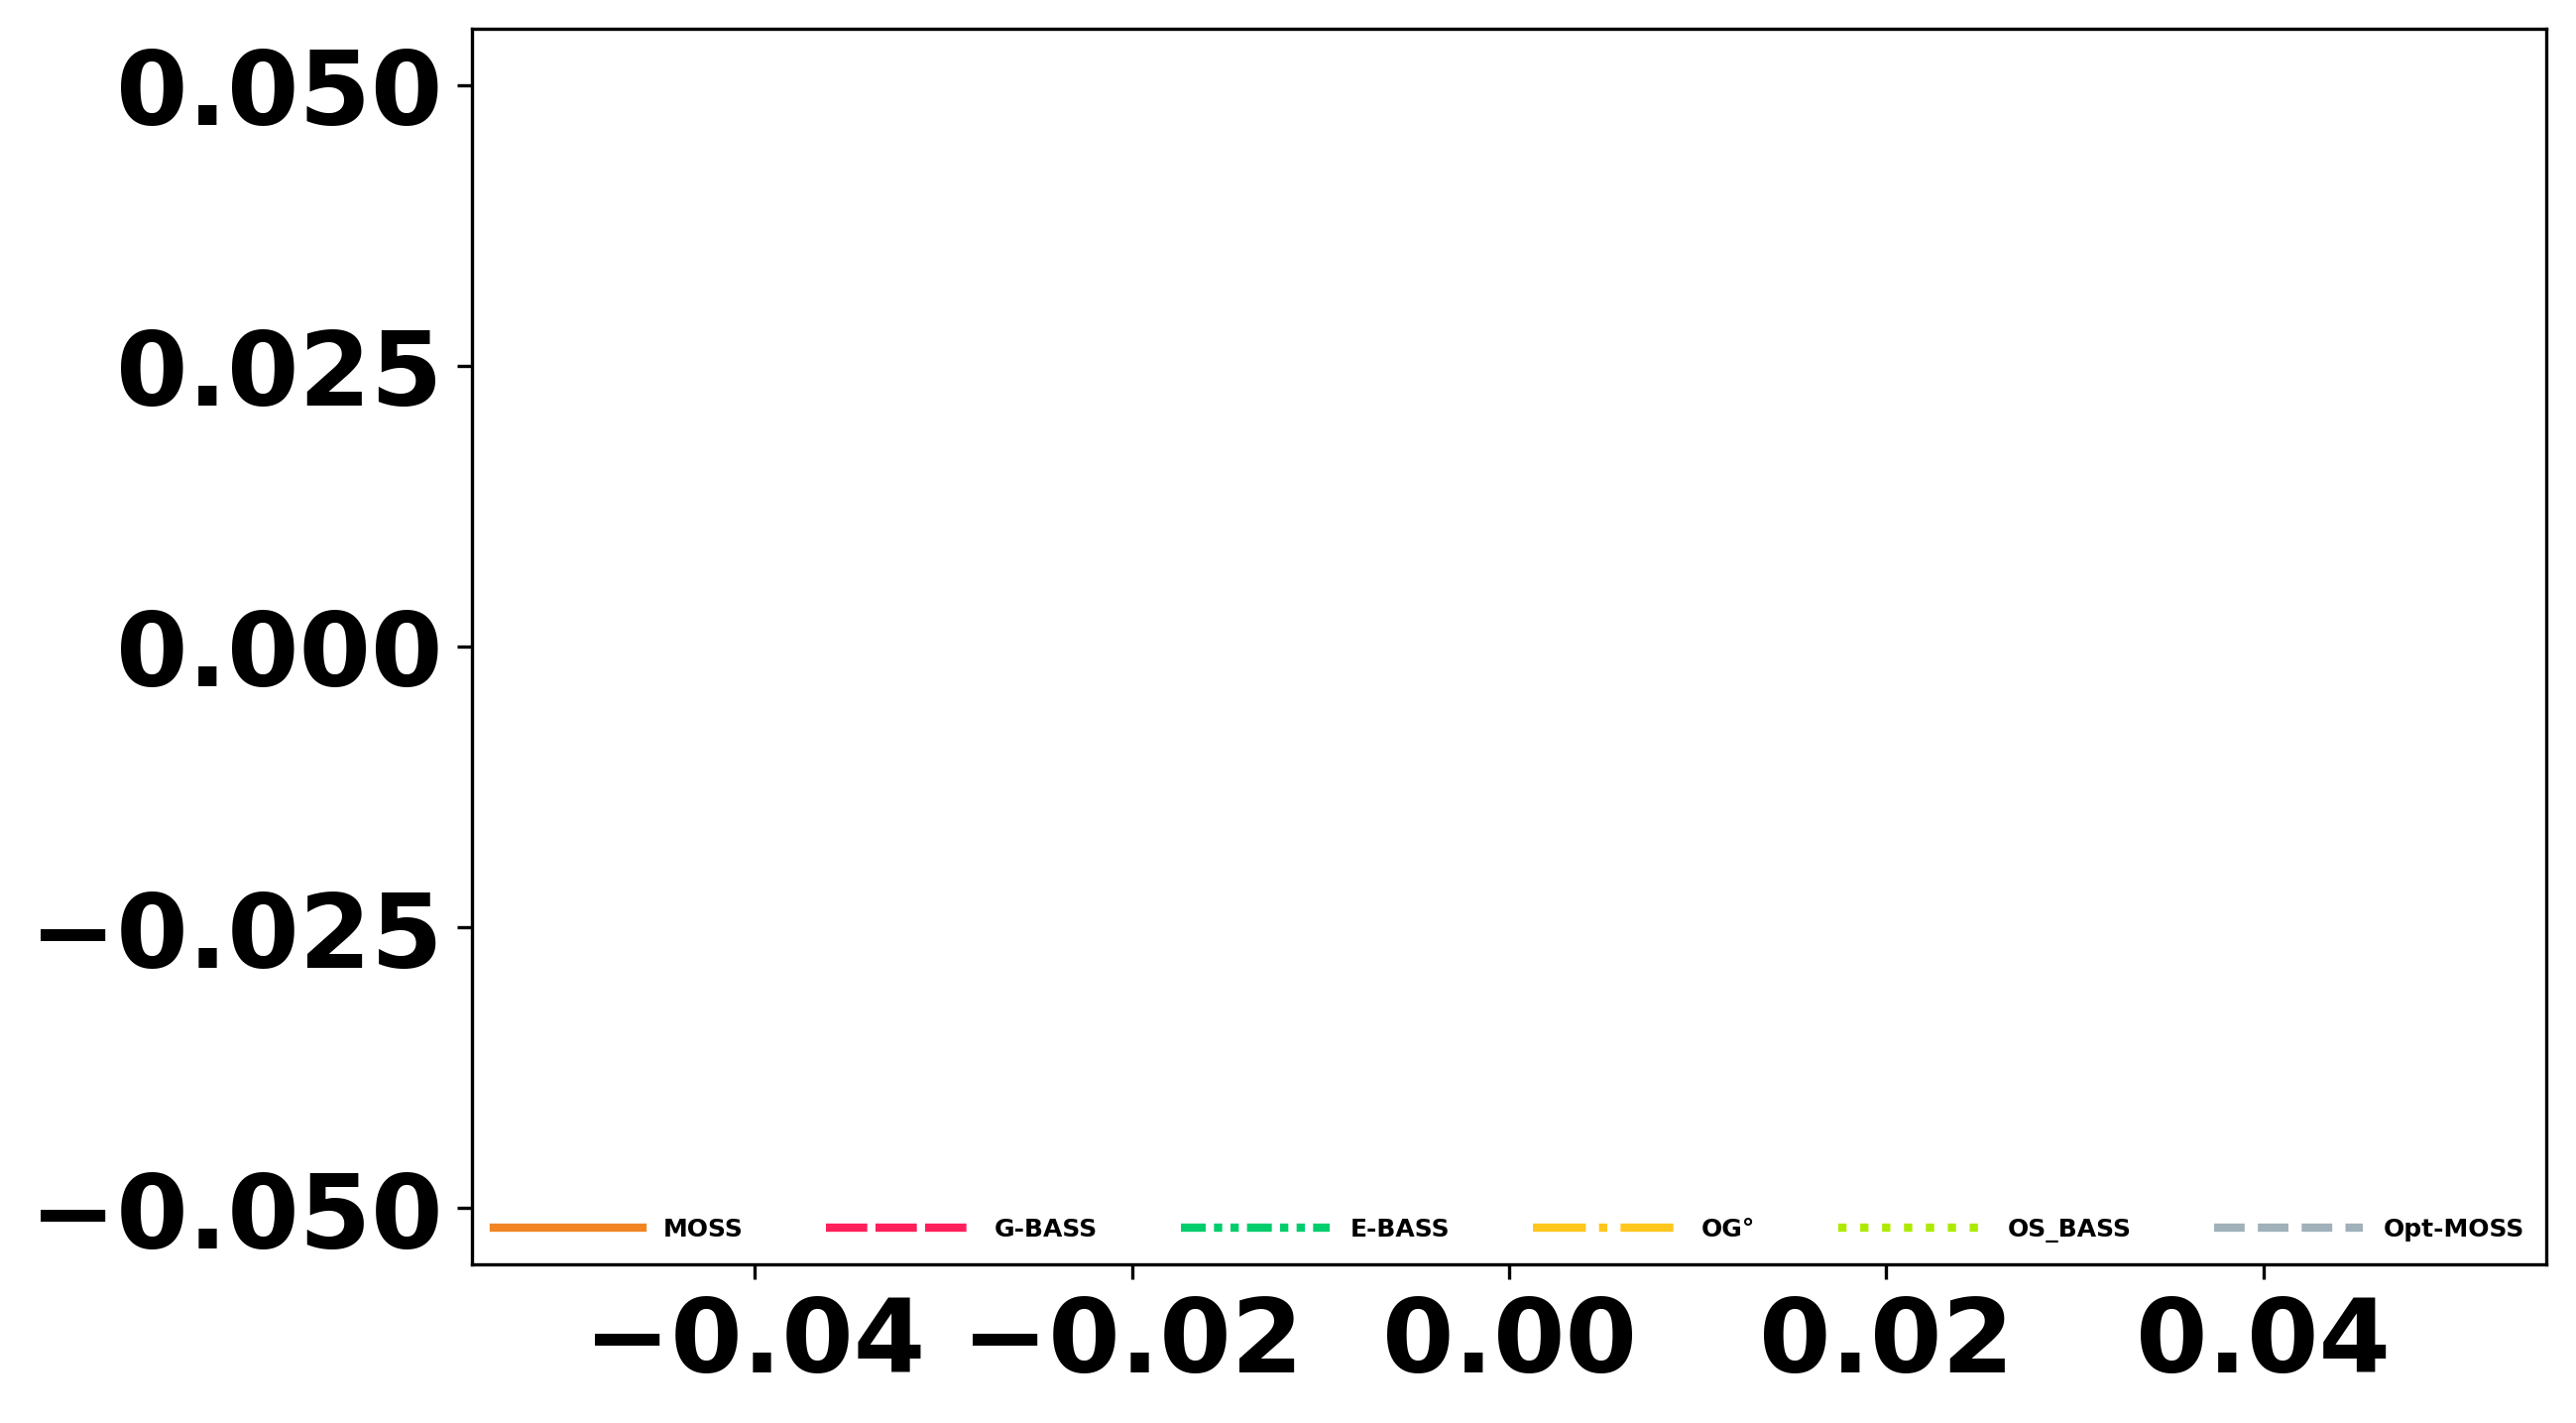

In [3]:
# # labels = ["MOSS", "G-BASS", "OG°", "OS-BASS", "Opt-MOSS"]
labels = ["MOSS", "G-BASS", "E-BASS", "OG°", "OS_BASS", "Opt-MOSS"]
# colors = ["#F28522", "#FF1F5B", "#FFC61E", "#AEEA00", "#A0B1BA"]
colors = ["#F28522", "#FF1F5B", "#00CD6C", "#FFC61E", "#AEEA00", "#A0B1BA"]
# linestyles = ["-", (0, (5, 1)), "-.", "dotted", "--" ]
linestyles = ["-", (0, (5, 1)), (0, (3,1,1,1,1, 1)), "-.", "dotted", "--"]
f = lambda c,l: plt.plot([],[], color=c, ls=l, linewidth=2)[0]
handles = [f(colors[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc='lower left', framealpha=1, frameon=False, mode="expand", 
                    ncol=6, handlelength=6)

def export_legend(legend, filename="legend6.png"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)

export_legend(legend)
plt.show()